In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import contextily as cx
import datetime as dt
import json
from joblib import Parallel, delayed

from functions_file import *
print(testfunction(4))

16


## Process data
First, reformat data from MSs and LDs for all polygons. Then gather and save the data in one file.

### 1. Reformat MS and LD data

**Key settings for reformatting**

In [2]:
polygons = pd.read_csv('../data/polygons11.csv')
polygons = polygons.drop([4])
polygons['polygon'] = polygons.name
poly_cols = ['polygon','lanes','direction','busstops','seplane','length','complexity','road_rank']

savefactors = {}
scalefactorsfile = 'scalefactors_bypolygon.pkl' # 'scalefactors_bypolygon_bymode.pkl'

# LD and MS data should have same resampling
resample = '30s' #30s
window = '3T' # 3min #3T
polygon_names = polygons.name.values

In [3]:
polygon_name = polygon_names[0]
POLYGON = get_polygon(polygon_name,polygons)
nonresampled = import_sensor_data(POLYGON['name'],'MS')
#mode = 'Car'
#moede_sel = nonresampled[nonresampled['mode']==mode]
#exp_sec = moede_sel[moede_sel['exp_id']==1]
nonresampled.head(25)['times']

0     [[[2018-10-24 08:31:13, 2018-10-24 08:31:43, 2...
1     [[[2018-10-24 09:01:00, 2018-10-24 09:01:30, 2...
2     [[[2018-10-24 09:31:00, 2018-10-24 09:31:30, 2...
3     [[[2018-10-24 10:01:31, 2018-10-24 10:02:01, 2...
4     [[[2018-10-24 10:31:00, 2018-10-24 10:31:30, 2...
5     [[[2018-10-25 08:01:05, 2018-10-25 08:01:35, 2...
6     [[[2018-10-25 08:31:00, 2018-10-25 08:31:30, 2...
7     [[[2018-10-25 09:31:00, 2018-10-25 09:31:30, 2...
8     [[[2018-10-25 10:01:04, 2018-10-25 10:01:34, 2...
9     [[[2018-10-30 08:01:10, 2018-10-30 08:01:40, 2...
10    [[[2018-10-30 08:31:00, 2018-10-30 08:31:30, 2...
11    [[[2018-10-30 09:04:48, 2018-10-30 09:05:18, 2...
12    [[[2018-10-30 09:31:39, 2018-10-30 09:32:09, 2...
13    [[[2018-10-30 10:01:00, 2018-10-30 10:01:30, 2...
14    [[[2018-11-01 08:31:00, 2018-11-01 08:31:30, 2...
15    [[[2018-11-01 09:01:29, 2018-11-01 09:01:59, 2...
16    [[[2018-11-01 09:31:29, 2018-11-01 09:31:59, 2...
17    [[[2018-11-01 10:01:03, 2018-11-01 10:01:3

#### Save scalefactors

In [4]:
scalefactorsfile = 'scalefactors_bypolygon.pkl' # 'scalefactors_bypolygon_bymode.pkl'
# save scalefactors
with open(scalefactorsfile, 'wb') as f:
    pickle.dump(savefactors, f)    
# to read
with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)

### 2. Gather all data
Bring together the Edies and the loop detector data, Edies with the parked vehicles and loop detectors without (should not make a difference)

In [5]:
save = 'off'

# 1. load and merge data
#all_MS = pd.concat( [pd.read_pickle('../output/data_processed_with_parked_5s/processed_data_MS_%s.pkl'%(p)) for p in polygons.name.values] )
all_MS = pd.concat( [pd.read_pickle('../output/data_processed/processed_data_MS_%s.pkl'%(p)) for p in polygons.name.values] )
all_LD = pd.concat( [pd.read_pickle('../output/data_processed/processed_data_LD_%s.pkl'%(p)) for p in polygons.name.values] )
vqk_cols_MS = [col for col in all_MS if col.startswith(('q_','v_','k_'))]
vqk_cols_LD = [col for col in all_LD if col.startswith(('q_','v_','k_'))]
all_MS.columns = [a+'_MS' if a in vqk_cols_MS else a for a in all_MS.columns]
all_LD.columns = [a+'_LD' if a in vqk_cols_LD else a for a in all_LD.columns]
non_vqk_cols = [col for col in all_MS if not col.startswith(('q_','v_','k_'))]
all_data = pd.merge(all_MS, all_LD, how='outer',on=non_vqk_cols,suffixes = ("_MS","_LD"))

# 2.a. set tiny values to zero
vqk_cols = [col for col in all_data if col.startswith(('q_','v_','k_'))]
for c in vqk_cols:
    tmp = all_data[c]
    tmp = [0 if a<1e-10 else a for a in tmp]
    all_data[c] = tmp
# 2.b. drop where ALL of [v,q,k] in [0,nan] --> either no traffic or no footage because in between recordings
leninit = len(all_data)
all_data = all_data.loc[~(all_data[vqk_cols].isin([0,np.nan])).all(axis=1)]
print('%.1f%% removed due to ambiguity (no traffic or no data?). New length: %s.'%(100*(1-len(all_data)/leninit),len(all_data)))

# 3. replace q and k NaNs with 0s
all_q_k_cols = [col for col in all_data if col.startswith(('q_','k_'))]
all_data[all_q_k_cols] = all_data[all_q_k_cols].fillna(0)
print('\nNaNs:\n',all_data[[col for col in all_data if col.startswith(('q_','v_','k_'))]].isna().sum())

# 4. save
if save=='on':
    #all_data.to_pickle('../output/processed_data/processed_data_all_bypolygonandmode.pkl') # index=False
    all_data.to_pickle('../output/data_processed_with_parked/processed_data_all_bypolygon.pkl') # index=False
display(all_data.head(3))
print('Saved.')
print('Length:',len(all_data))

69.4% removed due to ambiguity (no traffic or no data?). New length: 4675.

NaNs:
 v_Taxi_MS               168
k_Taxi_MS                 0
q_Taxi_MS                 0
v_Car0050_MS            983
k_Car0050_MS              0
q_Car0050_MS              0
v_Car_MS                 38
k_Car_MS                  0
q_Car_MS                  0
v_Heavy Vehicle_MS     2227
k_Heavy Vehicle_MS        0
q_Heavy Vehicle_MS        0
v_all_MS                  6
k_all_MS                  0
q_all_MS                  0
v_Medium Vehicle_MS     675
k_Medium Vehicle_MS       0
q_Medium Vehicle_MS       0
v_Bus_MS               1291
k_Bus_MS                  0
q_Bus_MS                  0
v_Motorcycle_MS         106
k_Motorcycle_MS           0
q_Motorcycle_MS           0
v_all_LD                237
k_all_LD                  0
q_all_LD                  0
dtype: int64


,exp_id,polygon,DOW,times,v_Taxi_MS,k_Taxi_MS,q_Taxi_MS,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,...,lanes,direction,busstops,seplane,length,complexity,road_rank,v_all_LD,k_all_LD,q_all_LD
0,1.0,polygon_r0,Wed,2018-10-24 08:31:00,36.983537,0.264116,0.237325,NaN,0.000000,0.000000,...,3,170,0,1,0.105,1,0,41.994024,1.282766,2.037116
1,1.0,polygon_r0,Wed,2018-10-24 08:31:30,42.355535,0.228994,0.231070,45.449044,0.163176,0.180186,...,3,170,0,1,0.105,1,0,46.472627,1.849675,3.346691
2,1.0,polygon_r0,Wed,2018-10-24 08:32:00,28.237023,0.152663,0.154047,22.724522,0.081588,0.090093,...,3,170,0,1,0.105,1,0,46.237944,1.429280,2.570646


Saved.
Length: 4675


### 3. Check some stuff

#### Check q-k plot of normalized data

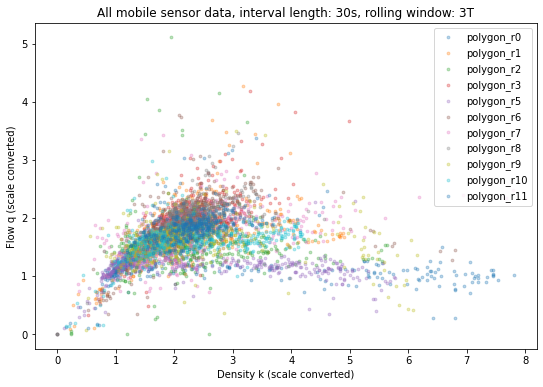

414
430
426
430
419
429
413
428
427
429
430


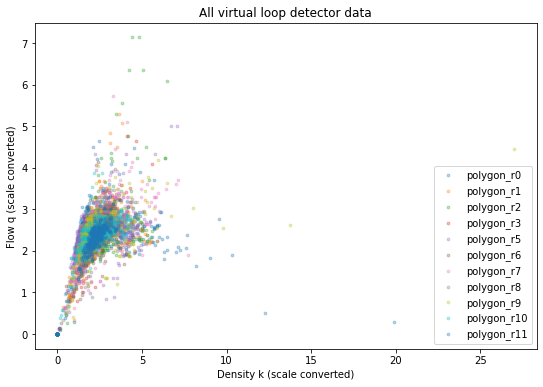

4675


In [6]:
data = all_data 
k_alls=[]
q_alls=[]
# allMS data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_MS,subset.q_all_MS,s=8,alpha=0.3,label=subset.polygon.values[0])
    for k in subset.k_all_MS:
        k_alls.append(k)
    for q in subset.q_all_MS:
        q_alls.append(q)
plt.title('All mobile sensor data, interval length: %s, rolling window: %s'%(resample,window))
plt.xlabel('Density k (scale converted)'); plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_MS_scaled.png')
plt.show()

# allLD data
plt.figure(figsize=(9,6))
for i in [0,1,2,3,5,6,7,8,9,10,11]:
    subset = data[data.polygon=='polygon_r%s'%i]
    plt.scatter(subset.k_all_LD,subset.q_all_LD,s=8,alpha=0.3,label=subset.polygon.values[0])
    print(len(subset.q_all_LD))
plt.title('All virtual loop detector data')
plt.xlabel('Density k (scale converted)');plt.ylabel('Flow q (scale converted)'); plt.legend()
#plt.savefig('All_LD_scaled.png')
plt.show()
print(len(all_data))

In [7]:
all_data['diff_1_all_MS'] = all_data.groupby('exp_id')['v_all_MS'].diff()
all_data['diff_2_all_MS'] = all_data.groupby('exp_id')['v_all_MS'].diff(periods=2)
all_data['diff_3_all_MS'] = all_data.groupby('exp_id')['v_all_MS'].diff(periods=3)

In [8]:
# Calculate threshold either per polygon and exp_id --> outdated! because we look at the whole time, not only a single exp id
quant_25 = all_data.groupby(['polygon','exp_id']).v_all_MS.quantile(.4)
quant_50 = all_data.groupby(['polygon','exp_id']).v_all_MS.quantile(.5)
quant_mean = all_data.groupby(['polygon','exp_id']).v_all_MS.mean()
quant_mean_half = all_data.groupby(['polygon','exp_id']).v_all_MS.mean()/2
quant_mean_half = all_data.groupby(['polygon','exp_id']).v_all_MS.mean()/2
all_data['threshold'] = np.zeros(len(all_data))
#for every polygon and exp id -> set the threshold as 40 % quantile
for key in quant_25.keys():
    all_data['threshold'] = np.where(((all_data.polygon==key[0]) & (all_data.exp_id == key[1])),
                                         quant_25[key],all_data['threshold'])
all_data['diff_to_threshold_quantile'] = all_data.v_all_MS-all_data.threshold

In [10]:
# or only per polygon
quant_25 = all_data.groupby(['polygon','exp_id']).v_all_MS.quantile(.25)
all_data['threshold'] = np.zeros(len(all_data))
for key in quant_25.keys():
    all_data['threshold'] = np.where((all_data.polygon==key[0]), quant_25[key],all_data['threshold'])
all_data['diff_to_threshold_quantile'] = all_data.v_all_MS-all_data.threshold

In [11]:
# mark every interval, where the current and the past two intervals are beneath the threshold
all_data['density_induced'] = False
all_data['density_induced'] = np.where(((all_data.diff_to_threshold_quantile<=0)
                                       & (all_data['diff_1_all_MS']>= all_data.diff_to_threshold_quantile) 
                                       & (all_data['diff_2_all_MS']>= all_data.diff_to_threshold_quantile)),
                                       True,all_data['density_induced'])


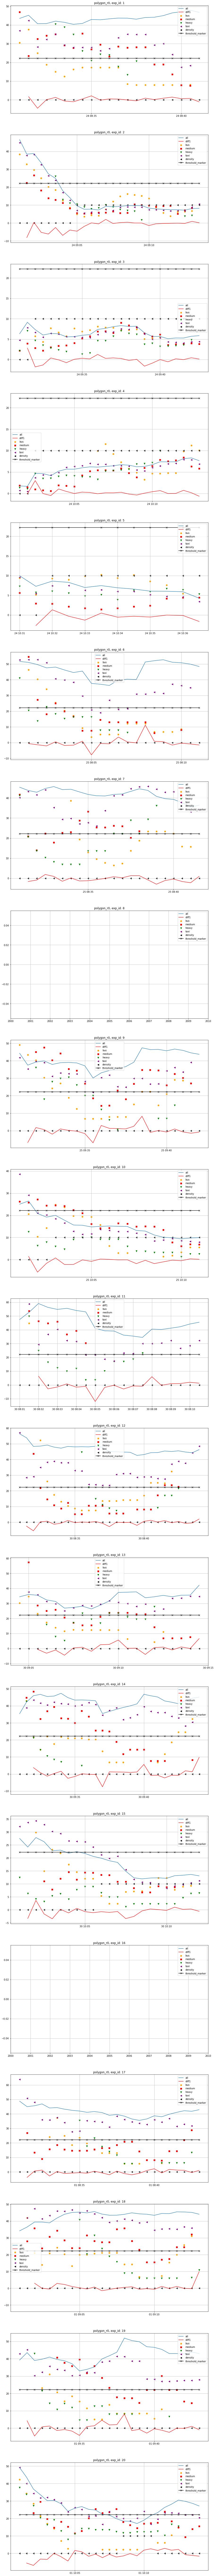

In [12]:
polygon = 0
polygon_str = 'polygon_r%s'%(polygon)
r_pol = all_data[(all_data.polygon==polygon_str)]

r_pol['v_Bus_MS'] = np.where((r_pol.q_Bus_MS < 0.001),None,r_pol.v_Bus_MS)
r_pol['v_Medium Vehicle_MS'] = np.where((r_pol['q_Medium Vehicle_MS'] < 0.001),None,r_pol['v_Medium Vehicle_MS'])
r_pol['v_Heavy Vehicle_MS'] = np.where((r_pol['q_Heavy Vehicle_MS'] < 0.001),None,r_pol['v_Heavy Vehicle_MS'])
r_pol['v_Taxi_MS'] = np.where((r_pol['q_Taxi_MS'] < 0.001),None,r_pol['v_Taxi_MS'])
#"." , "," , "o" , "v" , "^" , "<", ">"]
fig, axs = plt.subplots(20, figsize = (15,200))
for a in range(1,21):
    pol_exp_id = r_pol[r_pol.exp_id==a].sort_values('times')
    axs[a-1].plot(pol_exp_id.times, pol_exp_id.v_all_MS)#,s=8,alpha=0.8)
    axs[a-1].plot(pol_exp_id.times, pol_exp_id.diff_1_all_MS, c='red')#,s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id.v_Bus_MS,c='orange',marker="o")#s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id['v_Medium Vehicle_MS'],marker = ",",c='red')#, s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id['v_Heavy Vehicle_MS'],marker = "v",c='green')#,s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id['v_Taxi_MS'],marker = "<",c='purple')#,s=8,alpha=0.8)
    axs[a-1].scatter(pol_exp_id.times, pol_exp_id.density_induced*10,marker = "<",c='black')#,s=8,alpha=0.8)
    axs[a-1].plot(pol_exp_id.times, pol_exp_id.threshold,marker = "x",c='black')#,s=8,alpha=0.8)
    axs[a-1].title.set_text(polygon_str+', exp_id: '+str(a))
    axs[a-1].legend(['all','diff1','bus','medium','heavy','taxi','density','threshold_marker'])
    axs[a-1].grid()

In [101]:
all_data.to_pickle('../output/data_processed/processed_data_all_bypolygon_speed_diff.pkl') # index=False
display(all_data.head(3))
print('Saved.')
print('Length:',len(all_data))

,exp_id,polygon,DOW,times,v_Taxi_MS,k_Taxi_MS,q_Taxi_MS,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,...,road_rank,v_all_LD,k_all_LD,q_all_LD,diff_1_all_MS,diff_2_all_MS,diff_3_all_MS,threshold,diff_to_threshold_quantile,density_induced
0,1.0,polygon_r0,Wed,2018-10-24 08:31:00,36.983537,0.264116,0.237325,NaN,0.000000,0.000000,...,0,41.994024,1.282766,2.037116,NaN,NaN,NaN,22.218664,21.286990,False
1,1.0,polygon_r0,Wed,2018-10-24 08:31:30,42.355535,0.228994,0.231070,45.449044,0.163176,0.180186,...,0,46.472627,1.849675,3.346691,1.700375,NaN,NaN,22.218664,22.987365,False
2,1.0,polygon_r0,Wed,2018-10-24 08:32:00,28.237023,0.152663,0.154047,22.724522,0.081588,0.090093,...,0,46.237944,1.429280,2.570646,-4.499670,-2.799294,NaN,22.218664,18.487695,False


Saved.
Length: 4675
